In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import doc_retention_utils as dr
import lmfit

print(lmfit.__version__)

1.3.2


# Read in data

In [2]:
df = pd.read_csv(r'data/combined_data_2025-04.csv')

df

,Site,Type,tau,mo_mi,Source
0,1,catchment,1.400000,0.630,C2016
1,2,catchment,0.500000,0.680,C2016
2,3,catchment,0.500000,0.690,C2016
3,4,catchment,0.500000,0.560,C2016
4,5,catchment,2.600000,0.530,C2016
...,...,...,...,...,...
87,"Glensaugh, Scotland",river,0.000114,0.770,This study
88,"Medium river, MA (USA)",river,0.013699,0.850,This study
89,"Peaty headwater, NE Scotland",river,0.000576,0.863,This study
90,"River Tees, UK",river,0.007991,0.415,This study


# Fit models

In [3]:
print("\n\nFit for Vollenweider, constant sigma")
voll_fit1 = dr.fit_model(dr.transmission_sigma_constant, df, "tau", "mo_mi")

print("\n\nFit for Vollenweider, varying sigma")
voll_fit2 = dr.fit_model(dr.transmission_sigma_as_func_of_tau, df, "tau", "mo_mi")

print("\n\nFit for 'exponential decay', constant k")
exp_fit1 = dr.fit_model(dr.transmission_k_constant, df, "tau", "mo_mi")

print("\n\nFit for 'exponential decay', k=f(t)")
exp_fit2 = dr.fit_model(dr.transmission_k_as_func_of_tau, df, "tau", "mo_mi")



Fit for Vollenweider, constant sigma
[[Model]]
    Model(transmission_sigma_constant)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 92
    # variables        = 1
    chi-square         = 4.08003281
    reduced chi-square = 0.04483553
    Akaike info crit   = -284.642886
    Bayesian info crit = -282.121098
    R-squared          = -0.02110599
[[Variables]]
    sigma:  0.41627274 +/- 0.05093598 (12.24%) (init = 0.5)
R2: 0.03


Fit for Vollenweider, varying sigma
[[Model]]
    Model(transmission_sigma_as_func_of_tau)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 92
    # variables        = 2
    chi-square         = 2.38751502
    reduced chi-square = 0.02652794
    Akaike info crit   = -331.941265
    Bayesian info crit = -326.897688
    R-squared          = 0.40247885
[[Variables]]
    a:  0.66404693 +/- 0.05140329 (7.74%) (init = 0.5)
    b: -0.72761614 +/- 0.0458503

# Calculate additional performance stats

In [4]:
model_dict = {'Vollenweider fit 1': voll_fit1,
              'Vollenweider fit 2': voll_fit2,
              'Exp fit 1': exp_fit1,
              'Exp fit 2': exp_fit2}

predictions_df = df.copy()
results_list = []

for model_name in model_dict.keys():
    mae, mbd = dr.calculate_mae_and_mbd(model_dict[model_name], df, "tau", "mo_mi")
    print(model_name)
    print(f"Mean Absolute Error (MAE): {np.round(mae, 2)}")
    print(f"Mean Bias Deviation (MBD): {np.round(mbd, 2)}")
    print("\n")

    model = model_dict[model_name]
    predictions_df[f'pred_T_{model_name}'] = model.eval(params=model.params, **{'tau': predictions_df['tau'].values})
    predictions_df[f'{model_name}_error'] = predictions_df['mo_mi'] - predictions_df[f'pred_T_{model_name}']

# Manually add predictions from Catalan et al. (2016) & calculate error
predictions_df['pred_T_C2016'] = np.exp(-0.38 * df['tau'] ** 0.55)
predictions_df['C2016_error'] = predictions_df['mo_mi'] - predictions_df[f'pred_T_C2016']

mae = np.mean(np.abs(predictions_df['C2016_error']))
mbd = np.mean(predictions_df['C2016_error'])
print('C2016')
print(f"Mean Absolute Error (MAE): {np.round(mae, 2)}")
print(f"Mean Bias Deviation (MBD): {np.round(mbd, 2)}")
dr.rs_mae(df['mo_mi'], predictions_df['pred_T_C2016'], 'Catalan result')
print("BIC:")
dr.calculate_bic(df['mo_mi'], predictions_df['pred_T_C2016'], 2)

print("\n")

# Group by Type and calculate error
grouped = predictions_df.groupby('Type')

for group_name, group_data in grouped:
    group_results = {'Type': group_name}

    for model_name in list(model_dict.keys())+['C2016']:
        error_column = f'{model_name}_error'
        mae = np.mean(np.abs(group_data[error_column]))
        group_results[f'{model_name}_MAE'] = mae
        # mbd = np.mean(group_data[error_column])
        # group_results[f'{model_name}_MBD'] = mbd

    results_list.append(group_results)

error_df = pd.DataFrame(results_list)
error_df.set_index('Type', inplace=True)

# Display
error_df.round(2)

Vollenweider fit 1
Mean Absolute Error (MAE): 0.16
Mean Bias Deviation (MBD): -0.05


Vollenweider fit 2
Mean Absolute Error (MAE): 0.12
Mean Bias Deviation (MBD): -0.01


Exp fit 1
Mean Absolute Error (MAE): 0.18
Mean Bias Deviation (MBD): -0.07


Exp fit 2
Mean Absolute Error (MAE): 0.12
Mean Bias Deviation (MBD): -0.0


C2016
Mean Absolute Error (MAE): 0.14
Mean Bias Deviation (MBD): -0.05
Catalan result:
R2: 0.19 MAE: 0.14
BIC:
-298.3546184337319




,Vollenweider fit 1_MAE,Vollenweider fit 2_MAE,Exp fit 1_MAE,Exp fit 2_MAE,C2016_MAE
Type,,,,,
catchment,0.10,0.09,0.14,0.09,0.09
estuary,0.15,0.12,0.16,0.12,0.14
lake,0.18,0.13,0.20,0.12,0.15
reservoir,0.12,0.13,0.14,0.13,0.11
river,0.22,0.17,0.22,0.17,0.21


In [5]:
# Standard deviation of residuals

tau_values = np.logspace(np.log10(df["tau"].min()), np.log10(df["tau"].max()), 1000)

pred_voll1, pred_voll1_upper_params, pred_voll1_lower_params = (
    dr.generate_prediction_intervals(voll_fit1, tau_values, add_residual_error=False)
)
pred_voll1, pred_voll1_upper_full, pred_voll1_lower_full = (
    dr.generate_prediction_intervals(voll_fit1, tau_values, add_residual_error=True)
)

pred_voll2, pred_voll2_upper_params, pred_voll2_lower_params = (
    dr.generate_prediction_intervals(voll_fit2, tau_values, add_residual_error=False)
)
pred_voll2, pred_voll2_upper_full, pred_voll2_lower_full = (
    dr.generate_prediction_intervals(voll_fit2, tau_values, add_residual_error=True)
)

Standard deviation of residuals: 0.205
Standard deviation of residuals: 0.161


# Plot

In [6]:
# Read in extra data and rearrange data

# Split into rivers & not rivers
riv_df = df.loc[df['Type'] == 'river']
not_riv_df = df.loc[df['Type'] != 'river', :].copy()

# Also read in ocean_df data
ocean_df = pd.read_csv(r'data/C2016_oceanic_data.csv')

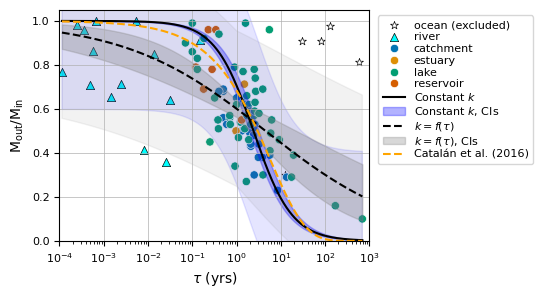

In [7]:
# Plot all models on one plot

fig, ax = plt.subplots(figsize=(4, 3))

# Plot ocean data that wasn't included in analysis
sns.scatterplot(
    data=ocean_df,
    x="tau",
    y="mo_mi",
    marker="*",
    edgecolor="black",
    facecolors="white",  #'none',
    label="ocean (excluded)",
)

# Plot observations, separating rivers from rest to highlight new contribution
sns.scatterplot(
    data=riv_df,
    x="tau",
    y="mo_mi",
    facecolors="cyan",
    edgecolor="black",
    marker="^",
    label="river",
)

sns.scatterplot(data=not_riv_df, x="tau", y="mo_mi", hue="Type", palette="colorblind")

# # Plot each model's fit
# tau_values = np.linspace(df['tau'].min(), df['tau'].max(), 100000)
tau_values = np.logspace(np.log10(df["tau"].min()), np.log10(df["tau"].max()), 1000)

ax.plot(tau_values, voll_fit1.eval(tau=tau_values), label=r"Constant $k$", color="k")

# Confidence intervals on Vollenweider with constant sigma
plt.fill_between(
    tau_values,
    pred_voll1_lower_params,
    pred_voll1_upper_params,
    color="blue",
    alpha=0.3,
    label=r"Constant $k$, CIs",
)
plt.fill_between(
    tau_values, pred_voll1_lower_full, pred_voll1_upper_full, color="blue", alpha=0.1
)  # , label=r'Constant $k$, full CI')

# ax.plot(tau_values, exp_fit1.eval(tau=tau_values), label='Exponential (constant $k$)', color='red')

ax.plot(
    tau_values,
    voll_fit2.eval(tau=tau_values),
    ls="--",
    label=r"$k = f(\tau$)",
    color="k",
)

# ax.plot(tau_values, exp_fit2.eval(tau=tau_values), ls='--', label=r'Exponential ($k = f(\tau$))', color='red')

# Confidence intervals on the Vollenweider with time-varying sigma
plt.fill_between(
    tau_values,
    pred_voll2_lower_params,
    pred_voll2_upper_params,
    color="gray",
    alpha=0.3,
    label=r"$k = f(\tau$), CIs",
)
plt.fill_between(
    tau_values, pred_voll2_lower_full, pred_voll2_upper_full, color="gray", alpha=0.1
)  # , label=r'$k = f(\tau$), full CI')

# Also plot implied results of Catalan's regression, when rearranged for Cout/Cin
trans_catalan = np.exp(-0.38 * tau_values**0.55)  # Double checked & ok
ax.plot(
    tau_values, trans_catalan, ls="--", label="Catalán et al. (2016)", color="orange"
)


plt.ylim(0, 1.05)
plt.xlim(0.0001, 1000)
# plt.xlim(0, 0.2)
plt.xscale("log")

plt.grid(True, which="major", linewidth=0.5)

# Add labels
plt.ylabel("$\mathrm{M_{out}/M_{in}}$", size=10)
plt.xlabel((r"$\tau$ (yrs)"), size=10)
plt.tick_params(axis="both", which="major", labelsize=8)
plt.tick_params(axis="both", which="minor", labelsize=8)

# Legend
ax.legend(fontsize=8, bbox_to_anchor=(1.01, 1), labelspacing=0.17)

# Add the plot location label in bold text to the top right corner
# plt.text(0.98, 0.98, '(a)', transform=plt.gca().transAxes, fontsize=12, fontweight='bold', ha='right', va='top')
# plt.text(0.1, 0.09, '(a)', transform=plt.gca().transAxes, fontsize=12, fontweight='bold', ha='right', va='top')

plt.savefig(r"graphs/trans-vs-tau_all-data_no-annotation.png", bbox_inches="tight")

# Show plot
plt.show()

# Comments

* Huge scatter in our transmission estimates, which is what models actually care about getting right (I think?)
* Slightly higher error in the stream data than in the other waterbody types. MAE of 0.14 instead of 0.12 (or 0.09 for "catchments").
* Slightly lower error when fitting to this "clean" dataset without bioassay data than when validating C2016's regression result against it (MAEs of 0.14 and 0.15 for estuaries and lakes, instead of 0.12; 0.17 for rivers instead of 0.14)
* Parameter-related error is generally smaller than residual error, sometimes a lot smaller.